In [1]:
using Plots; gr()
using NLsolve              # To solve non linear systems
using LaTeXStrings
using LinearAlgebra
using Distributions        # Needed for markov process function
using SpecialFunctions     # needed for Tauchen algorithm function
using Dierckx              # Spline interpolation


# PARAMETERS
# ==========

global chi  = 1.5          # Scale parameter of labor
global psi  = 1.0          # Elasticity of labor
global rho  = 1.01         # Elasiticty of consumption
global beta = 0.9

phi_grid    = range(0,     # Lagrange multiplier of the implementability constraint
              stop=1,
              length=30)     

global G    = [0.1 0.2]'   # State-space of government expenditures

global Pi   = [0.9 0.1;    # Markov transition matrix
               0.5 0.5];

# Part One
## Question 1 - $t \geq 1$

### (a) Plot the history-independent and time-invariant tax $\tau(\phi)$

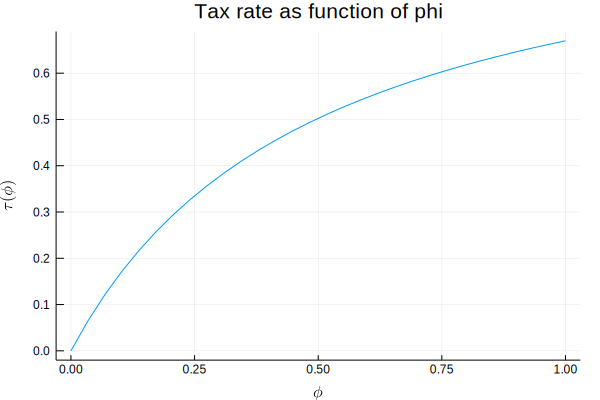

In [2]:
function tau(phi::Any)
    1 .- (1 .+ phi .* (1 - rho)) ./ (1 .+ phi .* (1 + psi))
end

plot(phi_grid, tau(phi_grid),
     title="Tax rate as function of phi",
     label="",
     xlabel=L"$\phi$",
     ylabel=L"$\tau(\phi)$")

   ### (b) Plot the history-independent ant time invariant allocations $\{c(\phi,g),n(\phi,g)\}$

We compute the allocations from the star equation and the ressource constraint using a non-linear solver. 
$$
\begin{cases}
(1+\phi) \big(u_c(g) + u_n(g)\big) + \phi \big(u_{cc}(g) c(g) +  n(g) u_{nn}(g)\big) &= 0\\
c(g) + g &= n(g)
\end{cases}
$$

In [33]:
"""
    starEquation(c, n, phi, b0)

Return the value of the star equation for a given consumption `c`, labor `n`, lagrange multiplier `phi`,
and initial debt b0. For t>0, use b0=0.

"""
function starEquation(c, n, phi, b0::Any=0)
    Uc  = c ^ (- rho)
    Ucc = - rho * c ^ (-rho - 1)
    Un  = - chi * n ^ psi
    Unn = - chi * psi * n ^ (psi - 1)
    
    return (1 + phi) * (Uc + Un) + phi * Ucc * (c - b0) + phi * Unn * n
end

starEquation

In [21]:
"""
    timeInvariantAllocation(g, phi)

Solves the time invariant allocation for a given government expenditure g and lagrange multiplier phi.
"""
function timeInvariantAllocation(g, phi)

    function f!(F, x)
        F[1] = x[1] - x[2] + g
        F[2] = starEquation(x[1], x[2], phi, 0)
    end

    nlsolve(f!, [0.5; 0.5])
end

"""
Compute the time invariant allocation for a given set of governement expenditures and lagrange multipliers

Arguments:
    G: a vector of possible values for the government expenditures
    phi: a vector of possible values for phi

Return:
    (C, N): a tuple of matrices where X[i, j] is the time invariant allocation of X for g[i] and phi[j]
"""
function timeInvariantAllocationVector(G, phi)
    C = zeros(length(G), length(phi))
    N = zeros(length(G), length(phi))

    for (i, g) in enumerate(G)
        for (j, phi) in enumerate(phi)
            roots   = timeInvariantAllocation(g, phi).zero
            C[i, j] = roots[1]
            N[i, j] = roots[2]
        end
    end

    return (C', N')
end

timeInvariantAllocationVector

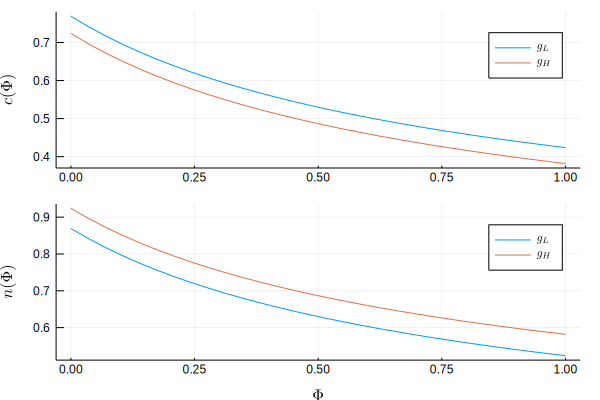

In [22]:
C, N = timeInvariantAllocationVector(G, phi_grid)

plot(
    layout=(2,1),
    plot(phi_grid, C,
        label=[L"g_L" L"g_H"],
        ylabel=L"$c(\Phi)$"
    ),
    plot(phi_grid, N,
        label=[L"g_L" L"g_H"],
        ylabel=L"$n(\Phi)$",
        xlabel=L"$\Phi$"
    )
)

## Question C

From the IC we have
$$
u_c(g) c(g) + u_n(g) n(g) + \beta \sum_{g'} \Pi(g'|g) u_c(g') b(g')= u_c(g) b(g)
$$
We rewrite the problem in matrix form to solve the linear system and because it makes it easy to compute $b$ for larger vector of states.
We have
$$
b = A b + k
$$
Where
$$
b   = [b_{g_1} \ldots b_{g_n}]' \\
A   = \beta \big((U_c)^{\odot - 1} U_c' \big) \odot \Pi \\
U_c = [u_{c,g_1} \ldots u_{c,g_n}]' \\
\Pi = \begin{bmatrix}
    \pi(g_1|g_1) & \ldots & \pi(g_n|g_1) \\
    \vdots       & \ddots & \vdots \\
    \pi(g_1|g_n) & \ldots & \pi(g_n|g_n)
\end{bmatrix} \\
k   = \begin{bmatrix}
    c_{g_1} + \frac{u_{n,g_1}}{u_{n,g_1}}n_{g_1} \\
    \vdots \\
    c_{g_n} + \frac{u_{n,g_n}}{u_{n,g_n}}n_{g_n} \\
\end{bmatrix}
$$

Where $\odot$ is the Hadamard product (or _elementwise_ operator)

The result is then given by
$$
b = (I - A)^{-1} k
$$

In [23]:
"""
    marginalUtilities(Consumption, Labor)
    
"""
function marginalUtilities(c::Adjoint, n::Adjoint)
    Uc = c.^(-rho)
    Un = -chi .* n .^ psi
    
    return (Uc, Un)
end

"""
    bonds(G, phi, Uc, Un, Pi, beta)

Returns:
    B : a (Nphi x NStates) matrix where B(i,j) is b(phi[i], G[i])
"""
function bonds(G, Pi, phi, beta)
    Nstates = length(G)
    Nphi    = length(phi)
    C, N    = timeInvariantAllocationVector(G, phi)
    Uc, Un  = marginalUtilities(C,N)
    b  = zeros(Nstates, Nphi)
    Id = Matrix{Float64}(I, Nstates, Nstates)
    for i in 1:Nphi #Iterate over all values of phi
        c = C[i,:]
        n = N[i,:]
        uc = Uc[i,:]
        un = Un[i,:]
        
        # The system writes:
        # b = Ab + K
        A  = beta .* (1 ./ uc) * uc' .* Pi
        k  = c .+ un./uc .* n
        
        b[:,i] = inv(Id - A) * k # We solve the system for a given phi
    end
    
    return b
end

bonds

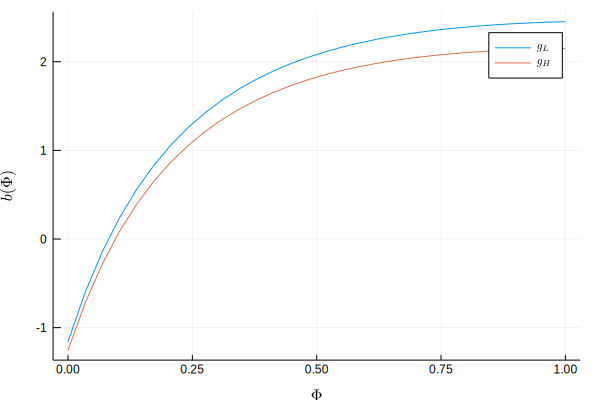

In [73]:
B = bonds(G, Pi, phi_grid, beta)';

plot(phi_grid, B,
    xlabel=L"$\Phi$",
    ylabel=L"$b(\Phi)$",
    label=[L"$g_L$", L"$g_H$"])

## Question two - $t=0$

### (a) Compute allocations $\{c_0(b_0, \phi), n_0(b_0, \phi)\}$

As before, we use the ressource constraint and the star equation, but in time zero.

In [25]:
"""
Solves the time invariant allocation for a given government expenditure g and lagrange multiplier phi
"""
function timeZeroAllocation(g, phi, b0)

    function f!(F, x)
        F[1] = x[1] - x[2] + g 
        F[2] = starEquation(x[1], x[2], phi, b0)
    end

    nlsolve(f!, [0.5; 0.5])
end

"""
Solves the time zero allocation for a vector of phi
"""
function timeZeroAllocationVector(g, phi, b0)
    C0 = zeros(length(phi), length(b0))
    N0 = zeros(length(phi), length(b0))
    
    for (i, phi) in enumerate(phi)
        for (j, b0) in enumerate(b0)
            roots   = timeZeroAllocation(g, phi, b0).zero
            C0[i, j] = roots[1]
            N0[i, j] = roots[2]
        end
    end
    
    return (C0, N0)
end

timeZeroAllocationVector

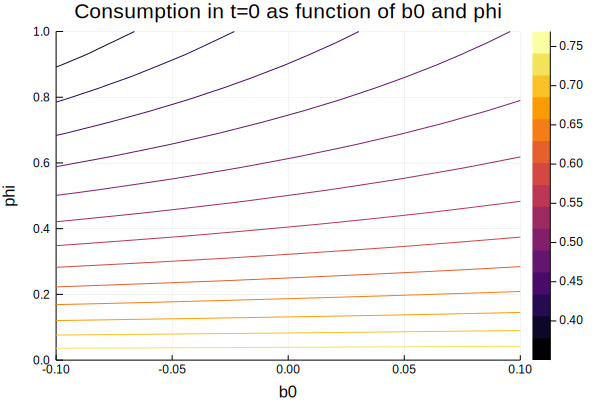

In [37]:
b0 = range(-0.1, stop=0.1, length=10)

C0, N0 = timeZeroAllocationVector(G[1], phi_grid, b0)

plot(b0, phi_grid, C0, linetype=:contour,
    xlabel= "b0",
    ylabel= "phi",
    zlabel= "C0",
    title="Consumption in t=0 as function of b0 and phi")

#sts = [:contour, :heatmap, :surface, :wireframe]
#plot(b0, phi_grid, C0, st = [:contour, :heatmap, :surface, :wireframe], layout = (2,2))

## Question B

In [38]:
"""
Bisection algorithm for root finding
"""

function bisec(f::Function, a, b, tol::AbstractFloat=1e-5, maxiter::Integer=100)
    fa = f(a)
    fa*f(b) <= 0 || error("No real root in [a,b]")
    i = 0
    local c
    while b-a > tol
        i += 1
        i != maxiter || error("Max iteration exceeded")
        c = (a+b)/2
        fc = f(c)
        if fc == 0
            break
        elseif fa*fc > 0
            a = c  # Root is in the right half of [a,b].
            fa = fc
        else
            b = c  # Root is in the left half of [a,b].
        end
    end
    return c
end

bisec (generic function with 3 methods)

In [43]:
"""
Compute the implementability constraint for the optimal allocation (c*, n*)
"""
function implementabilityConstraint(phi, b0)
    c, n = timeZeroAllocation(G[1], phi, b0).zero
    Uc  = c ^ (- rho)
    Ucc = - rho * c ^ (-rho - 1)
    Un  = - chi * n ^ psi
    Unn = - chi * psi * n ^ (psi - 1)
    return Uc * c + Un * n - Uc * b0
end

implementabilityConstraint

In [44]:
"""
Compute phi(b_0) using the implementability constraint

Args:
    b0 (float): The initial level of debt

Return:
    phi(b_0) (float)

"""
function phiFromb0(b0)
    phi_true = bisec(x -> implementabilityConstraint(x, b0), 0, 1)
    return phi_true
end

b0_grid = range(-0.099, stop = 0.1, length = 20)
phi_true_grid = zeros(length(b0_grid))
for (i, b0) in enumerate(b0_grid)
    phi_true_grid[i] = phiFromb0(b0)
end

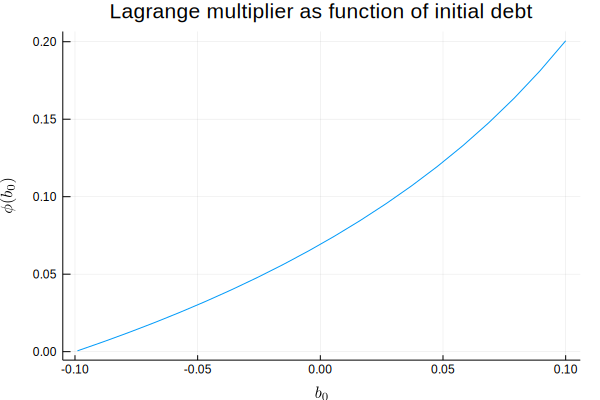

In [45]:
gr()
plot(b0_grid, phi_true_grid,
    title="Lagrange multiplier as function of initial debt",
    xlabel=L"$b_0$",
    ylabel=L"\phi(b_0)",
    label="")

# Part Three

In [46]:
using Random
function markovChainSimulation(transitionMatrix::Array, length::Integer, seed::Integer=42, initialState::Integer=1)
    chain = Array{Int32,1}(undef, length)
    chain[1] = initialState
    Nstates  = size(transitionMatrix)[1]
    Random.seed!(seed)
    for i in 2:length
        distribution = Multinomial(1, transitionMatrix[chain[i-1],:])
        chain[i]     = rand(distribution)' * (1:Nstates)
    end

    return chain
end

markovChainSimulation (generic function with 3 methods)

In [106]:
function simulateEconomy(states, b0::Float64, transitionMatrix::Array, N::Integer, seed::Integer=42, initialState::Integer=1)
    g, c, b, t, n = [zeros(N) for i in 1:6]
    
    chain = markovChainSimulation(transitionMatrix, N, seed, initialState)
    chain[1] = 0 # To avoid time 0 overwriting
    
    # Allocations in t=0
    # ==================
    g[1] = states[initialState]
    b[1] = b0
    phi  = phiFromb0(b0)
    c[1], n[1] = timeZeroAllocation(g[1], phi, b[1]).zero
    t[1] = 1 - ((chi * n[1]^psi) / (c[1]^(-rho)))
    t[2:end] .= tau(phi) # Tax rate is constant in t>1
    
    # Compute allocations for each states
    # ===================================
    for (i,) in enumerate(states)
        g[chain .== i] .= states[i]
        cons, labor = timeInvariantAllocation(states[i], phi).zero
        c[chain .== i] .= cons
        n[chain .== i] .= labor
        
        # We use spline approx to compute bonds from our previous computed matrix
        splineBonds = Spline1D(phi_grid, B[:,i])
        b[chain .== i] .= splineBonds(phi)
    end
    
    return g, c, n, b, t
end

simulateEconomy (generic function with 3 methods)

In [105]:
g, c, b, t, n = [zeros(100) for i in 1:6]
    
chain = markovChainSimulation(Pi, 100)
chain[1] = 0 # To avoid time 0 overwriting

# Allocations in t=0
# ==================
g[1] = G[1]
b[1] = 0.0
phi  = phiFromb0(b[1])
c[1], n[1] = timeZeroAllocation(g[1], phi, b[1]).zero
t[1] = 1 - ((chi * n^psi) / (c[1]^(-rho)))
#t[2:end] .= tau(phi) # Tax rate is constant in t>1

MethodError: MethodError: no method matching ^(::Array{Float64,1}, ::Float64)
Closest candidates are:
  ^(!Matched::Missing, ::Number) at missing.jl:93
  ^(!Matched::Float64, ::Float64) at math.jl:780
  ^(!Matched::Irrational{:ℯ}, ::Number) at mathconstants.jl:91
  ...

### (a) Assume $b_0=0$. Simulate the economy for 100 periods.

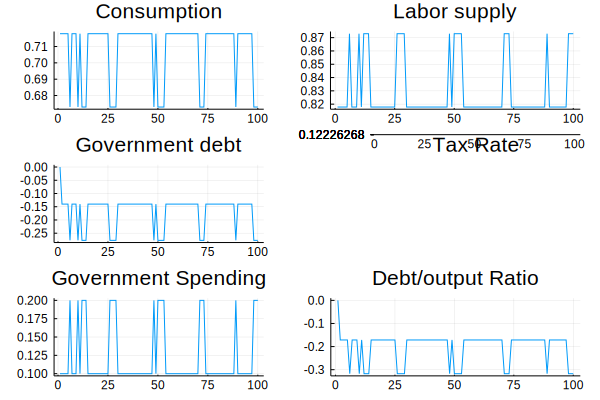

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW


In [110]:
function plotSimulatedEconomy(states, b0, transitionMatrix, periods, seed::Integer=42)
    g, c, n, b, t = simulateEconomy(states, b0, transitionMatrix, periods, seed);

    plot(layout=(3,2),
        plot(c, title="Consumption", label=""),
        plot(n, title="Labor supply", label=""),
        plot(b, title="Government debt", label=""),
        plot(t, title="Tax Rate", label=""),
        plot(g, title="Government Spending", label=""),
        plot(b./n, title="Debt/output Ratio", label=""),
    )
end

plotSimulatedEconomy(G, 0.0, Pi, 100)

### (b) Assume $b_0=0.1$. Simulate the economy for 100 periods.

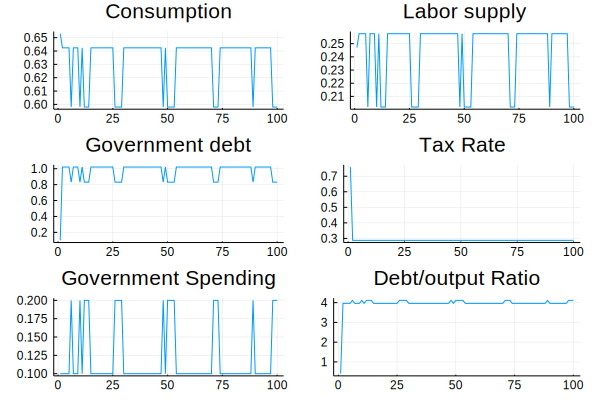

In [54]:
plotSimulatedEconomy(G, 0.1, Pi, 100)

### (c) Assume $b_0=-0.1$. Simulate the economy for 100 periods.

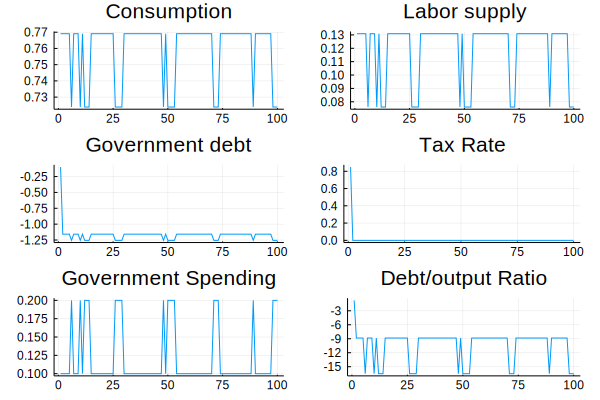

In [55]:
plotSimulatedEconomy(G, -0.09999, Pi, 100)

### (d) Extension, AR(1) process for g using Tauchen method

In [56]:
"""
Approximate AR1 with finite markov process
Proudly stolen on quantEcon github repository
https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/markov/markov_approx.jl
"""

std_norm_cdf(x::T) where {T <: Real} = 0.5 * erfc(-x/sqrt(2))
std_norm_cdf(x::Array{T}) where {T <: Real} = 0.5 .* erfc(-x./sqrt(2))

"""
Tauchen's (1996) method for approximating AR(1) process with finite markov chain
The process follows
    y_t = mu + rho y_{t-1} + epsilon_t

where epsilon_t sim N (0, sigma^2)

    Args:
        - N::Integer: Number of points in markov process
        - ρ::Real : Persistence parameter in AR(1) process
        - σ::Real : Standard deviation of random component of AR(1) process
        - μ::Real(0.0) : Mean of AR(1) process
        - n_std::Integer(3) : The number of standard deviations to each side the process
          should span
"""
function tauchen(N::Integer, ρ::Real, σ::Real, μ::Real=0.0, n_std::Integer=3)
    # Get discretized space
    a_bar = n_std * sqrt(σ^2 / (1 - ρ^2))
    y = range(-a_bar, stop=a_bar, length=N)
    d = y[2] - y[1]

    # Get transition probabilities
    Π = zeros(N, N)
    for row = 1:N
        # Do end points first
        Π[row, 1] = std_norm_cdf((y[1] - ρ*y[row] + d/2) / σ)
        Π[row, N] = 1 - std_norm_cdf((y[N] - ρ*y[row] - d/2) / σ)

        # fill in the middle columns
        for col = 2:N-1
            Π[row, col] = (std_norm_cdf((y[col] - ρ*y[row] + d/2) / σ) -
                           std_norm_cdf((y[col] - ρ*y[row] - d/2) / σ))
        end
    end

    # NOTE: I need to shift this vector after finding probabilities
    #       because when finding the probabilities I use a function
    #       std_norm_cdf that assumes its input argument is distributed
    #       N(0, 1). After adding the mean E[y] is no longer 0, so
    #       I would be passing elements with the wrong distribution.
    #
    #       It is ok to do after the fact because adding this constant to each
    #       term effectively shifts the entire distribution. Because the
    #       normal distribution is symmetric and we just care about relative
    #       distances between points, the probabilities will be the same.
    #
    #       I could have shifted it before, but then I would need to evaluate
    #       the cdf with a function that allows the distribution of input
    #       arguments to be [μ/(1 - ρ), 1] instead of [0, 1]

    yy = y .+ μ / (1 - ρ) # center process around its mean (wbar / (1 - rho)) in new variable

    # renormalize. In some test cases the rows sum to something that is 2e-15
    # away from 1.0, which caused problems in the MarkovChain constructor
    Π = Π./sum(Π, dims = 2)

    return Π, yy
end

tauchen

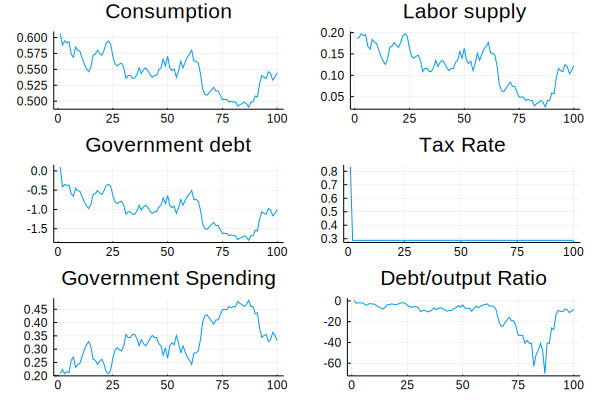

In [59]:
Pi_large, G_large = tauchen(100, 0.95, 0.2, 0.2)
G_large = G_large./10

B = bonds(G_large, Pi_large, phi_grid, beta)';
plotSimulatedEconomy(G_large, 0.1, Pi_large, 100)